<a href="https://colab.research.google.com/github/mominsiddiqui/Animal-Segmentation/blob/main/AnimalSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation for: Animal, Border and Background

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from google.colab.patches import cv2_imshow

np.random.seed(42)
tf.random.set_seed(42)

H = 256
W = 256

shape = (256, 256, 3)
num_classes = 3
lr = 1e-4
batch_size = 32
epochs = 10

##Loading Dataset

In [2]:
path = "/content/drive/MyDrive/oxford-iiit-pet"

In [3]:
def load_data(folder_path):
    train_valid_path = os.path.join(folder_path, "annotations/trainval.txt")
    test_path = os.path.join(folder_path, "annotations/test.txt")

    def process_data(data_path):
        df = pd.read_csv(data_path, sep=" ", header=None)
        names = df[0].values
        
        images = [os.path.join(folder_path, f"images/{name}.jpg") for name in names]
        masks = [os.path.join(folder_path, f"annotations/trimaps/{name}.png") for name in names]
        return images, masks

    train_x, train_y = process_data(train_valid_path)
    test_x, test_y = process_data(test_path)
    test_x, _ = train_test_split(test_x, test_size=0.99, random_state=42)
    test_y, _ = train_test_split(test_y, test_size=0.99, random_state=42)
            
    train_x, valid_x = train_test_split(train_x, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=0.2, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [4]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(f"Dataset:\nTrain: {len(train_x)} \nValid: {len(valid_x)} \nTest: {len(test_x)}")

Dataset:
Train: 2944 
Valid: 736 
Test: 36


##Reading Image and Mask From Specified File Path

In [5]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    #Values of x are [1,2,3], we want them to be [0,1,2]
    x = x - 1
    x = x.astype(np.int32)
    return x

##Preparing Data using tf.data

In [6]:
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(x)
        return image, mask
    
    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 3])
    return image, mask
        
def tf_dataset(x, y, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

##U-net Model

In [7]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def unet(shape, num_classes):
    inputs = Input(shape)

    # Encoding
    c1, p1 = conv_block(inputs, 16, pool=True)
    c2, p2 = conv_block(p1, 32, pool=True)
    c3, p3 = conv_block(p2, 64, pool=True)
    c4, p4 = conv_block(p3, 128, pool=True)
    
    # Bridge
    c5 = conv_block(p4, 256, pool=False)

    #Decoder
    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, 128, pool=False)

    u7 = u6 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, 64, pool=False)

    u8 = u6 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, 32, pool=False)

    u9 = u6 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, 16, pool=False)

    #Outer Layer
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(c9)

    return Model(inputs, output)

In [9]:
model = unet(shape, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

##Compile and Train Model

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
)

##Testing

In [ ]:
for x, y in zip(test_x, test_y):
  
    #Read Image
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)

    # Read Mask
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H)) 
    y = y - 1
    y = np.expand_dims(y, axis=-1)
    y = y * (255/num_classes)
    y = y.astype(np.int32)
    y = np.concatenate([y, y, y], axis=2)

    ## Prediction
    p = model.predict(np.expand_dims(x, axis=0))[0]
    p = np.argmax(p, axis=-1)
    p = np.expand_dims(p, axis=-1)
    p = p * (255/num_classes)
    p = p.astype(np.int32)
    p = np.concatenate([p, p, p], axis=2)
    
    x = x * 255.0
    x = x.astype(np.int32)
    
    h, w, _ = x.shape
    line = np.ones((h, 10, 3)) * 255
    final_image = np.concatenate([x, line, y, line, p], axis=1)
    cv2_imshow(final_image)
    print("\n")

##What Prediction Looks Like

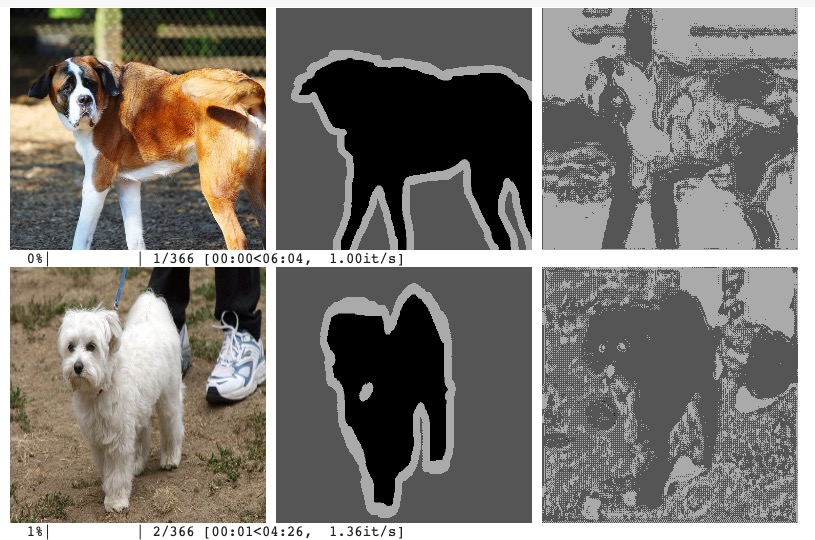